In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import numpy as np
import pandas as pd
import os
import getpass
import tensorflow as tf

/Users/JundongQiao/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pylab as plt
% matplotlib inline

In [4]:
tf.logging.set_verbosity(tf.logging.INFO) 
# Set to INFO for tracking training, default is WARN 

print("Using TensorFlow version %s" % (tf.__version__)) 

Using TensorFlow version 1.6.0


### Import Data

In [15]:
# Import Data
DATA_DIR ='/Users/{}/Dropbox/VirtualBeach/Regression'.format(getpass.getuser())
train_eval_test = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_2008_2018_16_features_target.csv'), header='infer', sep=',', index_col=0)
train_eval_test.reindex(range(len(train_eval_test)))

ecoli_threshold = 235.
X = train_eval_test.iloc[:,2:].copy()
y = train_eval_test.iloc[:,1].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2)

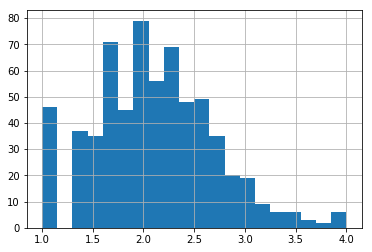

In [16]:
y.hist(bins=20);

In [17]:
# https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn
def generate_input_fn(df, labels, num_epochs=None, shuffle=True, batch_size=BATCH_SIZE):

    return tf.estimator.inputs.pandas_input_fn(
        x=df,
        y=labels,
        batch_size=batch_size,
        num_epochs=num_epochs,
        shuffle=shuffle)

print('input function configured')

input function configured


In [18]:
COLUMNS = list(X.columns)

In [19]:
COLUMNS

['Lake_Turb_NTU',
 'Local_Rain24_in',
 'BarPressureInst_inhg',
 'Stream_Turb_NTU',
 'WaveHt_Ft',
 'Perp_WaveDir_24hr',
 'AirportRain24_in',
 'WindDirInst_deg',
 'Perp_WaveHt_24hr',
 'CloudCover_24hr',
 'AirportRain48_in',
 'WindSpInst_mph',
 'NvWater_24hr',
 'AirportRain48W_in',
 'WaterTemp_24hr',
 'WindSpAnt24_mph']

### Continuous Columns

In [20]:
# Continuous base columns.
Lake_Turb_NTU = tf.feature_column.numeric_column("Lake_Turb_NTU")
Local_Rain24_in = tf.feature_column.numeric_column("Local_Rain24_in")
BarPressureInst_inhg = tf.feature_column.numeric_column("BarPressureInst_inhg")
WaveHt_Ft  = tf.feature_column.numeric_column("WaveHt_Ft")
Perp_WaveDir_24hr = tf.feature_column.numeric_column("Perp_WaveDir_24hr")

AirportRain24_in = tf.feature_column.numeric_column("AirportRain24_in")
WindDirInst_deg = tf.feature_column.numeric_column("WindDirInst_deg")
CloudCover_24hr = tf.feature_column.numeric_column("CloudCover_24hr")
AirportRain48_in  = tf.feature_column.numeric_column("AirportRain48_in")
WindSpInst_mph = tf.feature_column.numeric_column("WindSpInst_mph")

NvWater_24hr = tf.feature_column.numeric_column("NvWater_24hr")
AirportRain48W_in = tf.feature_column.numeric_column("AirportRain48W_in")
WaterTemp_24hr = tf.feature_column.numeric_column("WaterTemp_24hr")
WindSpAnt24_mph  = tf.feature_column.numeric_column("WindSpAnt24_mph")
Perp_WaveHt_24hr = tf.feature_column.numeric_column("Perp_WaveHt_24hr")

Stream_Turb_NTU = tf.feature_column.numeric_column("Stream_Turb_NTU")
print('Continuous columns configured')

Continuous columns configured


### Feature Transformation
* Bucketizing
* Crossing

In [10]:
X.AirportRain24_in.describe()

count    641.000000
mean       0.113510
std        0.285661
min        0.000000
25%        0.000000
50%        0.000000
75%        0.070000
max        2.490000
Name: AirportRain24_in, dtype: float64

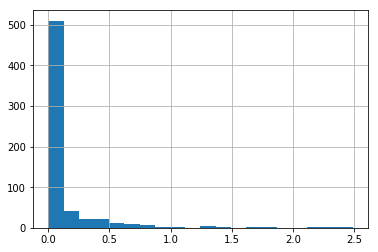

In [11]:
X.AirportRain24_in.hist(bins=20);

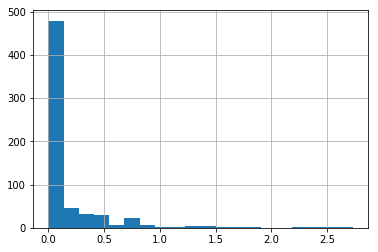

In [12]:
X.AirportRain48_in.hist(bins=20);

In [13]:
X.Perp_WaveHt_24hr.describe()

count    641.000000
mean      -0.339944
std        0.363270
min       -1.811840
25%       -0.546814
50%       -0.278813
75%       -0.071636
max        0.423006
Name: Perp_WaveHt_24hr, dtype: float64

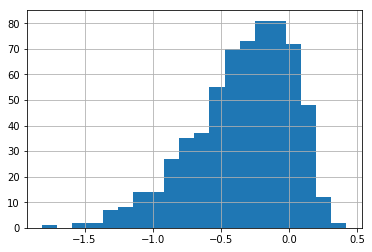

In [14]:
X.Perp_WaveHt_24hr.hist(bins=20);

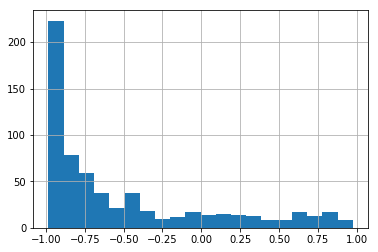

In [15]:
X.Perp_WaveDir_24hr.hist(bins=20);

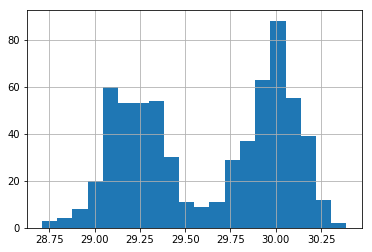

In [16]:
X.BarPressureInst_inhg.hist(bins=20);

In [18]:
X.BarPressureInst_inhg.describe()

count    641.000000
mean      29.626178
std        0.410317
min       28.710000
25%       29.240000
50%       29.730000
75%       30.000000
max       30.390000
Name: BarPressureInst_inhg, dtype: float64

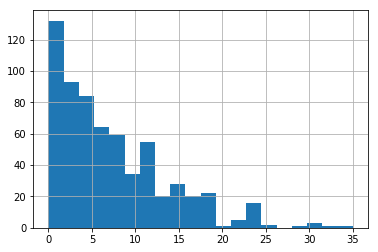

In [17]:
X.WaveHt_Ft.hist(bins=20);

In [11]:
# Transformations.
AirportRain24_in_buckets = tf.feature_column.bucketized_column(
    AirportRain24_in, boundaries=[ 0.25, 0.5, 0.75, 1., 1.5, 2., 2.5])
AirportRain48_in_buckets = tf.feature_column.bucketized_column(
    AirportRain48_in, boundaries=[ 0.25, 0.5, 0.75, 1., 1.5, 2., 2.5])

Perp_WaveDir_24hr_buckets = tf.feature_column.bucketized_column(
    Perp_WaveDir_24hr, boundaries = list(np.linspace(-1., 1., 9)))
Perp_WaveHt_24hr_buckets = tf.feature_column.bucketized_column(
    Perp_WaveHt_24hr, boundaries = list(np.linspace(-1.5, 0.5, 9)))

BarPressureInst_inhg_buckets = tf.feature_column.bucketized_column(
    BarPressureInst_inhg, boundaries = list(np.linspace(28.5, 30.5, 9)))
WaveHt_Ft_buckets = tf.feature_column.bucketized_column(
    WaveHt_Ft, boundaries = list(np.linspace(0, 35, 9)))

In [21]:
AirportRain_24_48 = tf.feature_column.crossed_column(
    [AirportRain24_in_buckets, AirportRain24_in_buckets], hash_bucket_size=int(1e6))

Perp_Wave_Dir_Ht = tf.feature_column.crossed_column(
    [Perp_WaveDir_24hr_buckets, Perp_WaveHt_24hr_buckets], hash_bucket_size=int(1e6))

BarPressureInst_WaveHt = tf.feature_column.crossed_column(
    [BarPressureInst_inhg_buckets, WaveHt_Ft_buckets], hash_bucket_size=int(1e6))

In [22]:
wide_columns = [AirportRain24_in_buckets, AirportRain48_in_buckets,
               Perp_WaveDir_24hr_buckets, Perp_WaveHt_24hr_buckets,
               AirportRain_24_48, Perp_Wave_Dir_Ht,
               BarPressureInst_inhg_buckets, WaveHt_Ft_buckets,
               BarPressureInst_WaveHt]

deep_columns = [Lake_Turb_NTU, Local_Rain24_in, BarPressureInst_inhg, Stream_Turb_NTU, WaveHt_Ft, 
                WindDirInst_deg, CloudCover_24hr, WindSpInst_mph, NvWater_24hr, WaterTemp_24hr, WindSpAnt24_mph]

*tf.estimator.DNNLinearCombinedRegressor*
https://www.tensorflow.org/api_docs/python/tf/estimator/DNNLinearCombinedRegressor
```
__init__(
    model_dir=None,
    linear_feature_columns=None,
    linear_optimizer='Ftrl',
    dnn_feature_columns=None,
    dnn_optimizer='Adagrad',
    dnn_hidden_units=None,
    dnn_activation_fn=tf.nn.relu,
    dnn_dropout=None,
    label_dimension=1,
    weight_column=None,
    input_layer_partitioner=None,
    config=None,
    warm_start_from=None,
    loss_reduction=losses.Reduction.SUM,
    batch_norm=False,
    linear_sparse_combiner='sum'
)
```

In [67]:
def create_model_dir(model_type):
    return 'WoodlawnBeach_Regression_models/model_' + model_type + str(int(time.time()))

# If new_model=False, pass in the desired model_dir 
def get_model(model_type, new_model=False, model_dir=None):
    if new_model or model_dir is None:
        model_dir = create_model_dir(model_type) # Comment out this line to continue training a existing model
    print("Model directory = %s" % model_dir)
    
    m = None
    
    # Linear Classifier
    if model_type == 'WIDE':
        m = tf.estimator.LinearRegressor(
            model_dir=model_dir, 
            feature_columns=wide_columns)

    # Deep Neural Net Classifier
    if model_type == 'DEEP':
        m = tf.estimator.DNNRegressor(
            model_dir=model_dir,
            feature_columns=deep_columns,
            hidden_units=[100, 50])

    # Combined Linear and Deep Classifier
    if model_type == 'WIDE_AND_DEEP':
        m = tf.estimator.DNNLinearCombinedRegressor(
                model_dir=model_dir,
                linear_feature_columns=wide_columns,
                linear_optimizer = 'Ftrl',
            
                dnn_feature_columns=deep_columns,
                dnn_optimizer= 'RMSProp',
                dnn_hidden_units=[200, 100, 75]
                )
        
    print('estimator built')
    
    return m, model_dir
    
MODEL_TYPE = 'WIDE_AND_DEEP'
model_dir = create_model_dir(model_type=MODEL_TYPE)
m, model_dir = get_model(model_type = MODEL_TYPE, model_dir=model_dir)

Model directory = WoodlawnBeach_Regression_models/model_WIDE_AND_DEEP1541111452
estimator built


In [68]:
%%time 
BATCH_SIZE = 16
m.train(input_fn=generate_input_fn(X_train_val, y_train_val, BATCH_SIZE), steps=2000)

print('fit done')

fit done
CPU times: user 12.4 s, sys: 1.42 s, total: 13.8 s
Wall time: 11 s


In [69]:
predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=len(X_test),
        num_epochs=1,
        shuffle=False)

In [70]:
results = m.evaluate(input_fn=generate_input_fn(X_test, y_test, num_epochs=1, shuffle=False), 
                     steps=None)
print('evaluate done')


evaluate done


In [71]:
results

{'average_loss': 0.28424206, 'global_step': 512, 'loss': 4.0741363}

In [63]:
from sklearn.metrics import r2_score

In [72]:
predictions = m.predict(input_fn=predict_input_fn)
y_pred = []
for prediction in predictions:
#     print (prediction)
#     print (prediction['predictions'][0])
    y_pred.append(prediction['predictions'][0])
    # print("Predictions:    {} with probabilities {}\n".format(prediction["classes"], prediction["probabilities"]))

In [73]:
print (r2_score(y_test, y_pred))

0.1761414859954612


(0, 3.5)

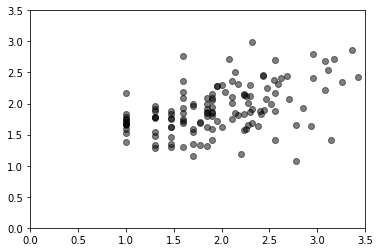

In [74]:
plt.plot(y_test, y_pred, 'ko', alpha=0.5)
plt.xlim((0, 3.5))
plt.ylim((0, 3.5))